# Estimating Eigenfunctions of the Transfer Operator

_Author_: [Pietro Novelli](https://pietronvll.github.io/)

This example is a reproduction of the second experiment of _"Sharp Spectral Rates for Koopman Operator Learning"_<cite data-footcite="Kostic2023SpectralRates">(Kostic et al. 2023)</cite>. We use `kooplearn` to approximate the leading eigenfunctions of the transfer operator of the overdamped Langevin dynamics
$$
X_{t + 1} = X_t -\frac{1}{\gamma}\nabla V(X_t)\Delta t + \frac{\sigma}{\gamma}\sqrt{\Delta t}\xi_t
$$
Here, $V$ is the potential function, $\gamma$ is a damping coefficient, and $\sigma$ is proportional to the temperature of the process: the higher the $\sigma$, the noisier is the dynamics. In this example we will study the so-called _Prinz Potential_<cite data-footcite="Prinz2011">(Prinz et al. 2011)</cite>:

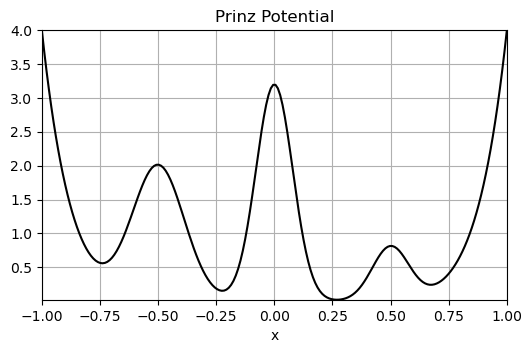

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [6., 3.5]

def prinz_potential(x):
    return 4 * (
        x**8
        + 0.8 * np.exp(-80 * (x**2))
        + 0.2 * np.exp(-80 * ((x - 0.5) ** 2))
        + 0.5 * np.exp(-40 * ((x + 0.5) ** 2))
    )

x = np.linspace(-1, 1, 200)
plt.plot(x, prinz_potential(x), 'k')
plt.margins(0)
plt.xlabel('x')
plt.title("Prinz Potential")
plt.grid()

`kooplearn` exposes the function [make_prinz_potential](../generated/kooplearn.datasets.make_prinz_potential.rst) to simulate the overdamped Langevin dynamics with this potential. 

In [2]:
from kooplearn.datasets import make_prinz_potential

gamma = 1.0
sigma = 2.0
data = make_prinz_potential(X0 = 0, n_steps=int(5e6), gamma=gamma, sigma=sigma)

for overdamped Langevin processes, the inverse temperature satisfies the relation $\beta = 2\gamma/\sigma^2$. With this, we can easily verify that `data` approximately samples the Boltzmann distribution $e^{-\beta V(x)}$.

Text(0.5, 0, 'x')

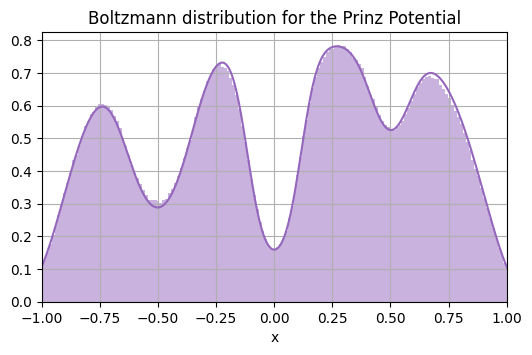

In [3]:
from scipy.integrate import romb


def compute_boltzmann_density(x, gamma, sigma):
    beta = 2*gamma/(sigma**2)
    pdf = np.exp(-beta*prinz_potential(x))
    total_mass = romb(pdf, dx=x[1] - x[0])
    return pdf/total_mass

x = np.linspace(-2, 2, 2048 + 1)
density = compute_boltzmann_density(x, gamma ,sigma)
plt.hist(data, bins=200, density=True, alpha=0.5, color="tab:purple")
plt.plot(x, density, color='tab:purple')
plt.xlim(-1, 1)
plt.grid()
plt.title("Boltzmann distribution for the Prinz Potential")
plt.xlabel("x")

### Estimating the eigenfunctions
We will compare the _Reduced Rank Regression_ estimator <cite data-footcite="Kostic2022">(Kostic et al. 2022)</cite> against the classical _Principal Component_ estimator, also known as kernel DMD <cite data-footcite="Williams2015_KDMD">(Williams et al. 2015)</cite>. To this end, we use `kooplearn`'s [KernelRidge](../generated/kooplearn.kernel.KernelRidge.rst) class, with a simple Gaussian kernel (`rbf`).

In [4]:
from kooplearn.kernel import KernelRidge

n_train_samples = 5001

def fit_and_estimate(reduced_rank, x, density, random_state):
    subsample = 100  # We need long trajectories to sample the Boltzmann distribution...
    gamma = 1.0
    sigma = 2.0
    data = make_prinz_potential(X0=0, n_steps=int(7e5), gamma=gamma, sigma=sigma, random_state=random_state)
    data = data.iloc[::subsample]  # ...but we don't need all the data to estimate the eigenfunctions
    data = data[:n_train_samples]
    model = KernelRidge(
        n_components=5, reduced_rank=reduced_rank, gamma=12.5, kernel="rbf", alpha=1e-6, random_state=random_state,
    )  # Model definition
    model.fit(data)
    values, functions = model.eig(eval_right_on=x)  # Eigenvalue estimation
    sort_perm = np.flip(np.argsort(np.abs(values))) # Order eigenvalues decreasingly
    values, functions = values[sort_perm], functions[:, sort_perm]
    functions = normalize_eigenfunctions(functions, x, density)
    return functions


def normalize_eigenfunctions(functions, x, density):
    abs2_eigfun = (np.abs(functions) ** 2).T  # f(x)**2
    abs2_eigfun *= density  # Compute the norm with respect to the Boltzmann measure.
    dx = x[1] - x[0]
    funcs_norm = np.sqrt(romb(abs2_eigfun, dx=dx, axis=1))  # Norms
    functions *= funcs_norm**-1.0  # Normalize
    return functions

The code above is straightforward: the function `fit_and_estimate` samples a fresh new trajectory, fits a transfer operator model, computes its (right) eigenfunctions via `model.eig`, and evaluates it on the array `x` via the argument `eval_right_on=x`. Finally, it computes the normalization constant
$$\left(\int e^{-\beta V(x)} |\psi(x)|^2dx\right)^{1/2} $$
via the `normalize_eigenfunctions` helper method. We now run this function for both Reduced Rank (`reduced_rank = True`) and Principal Component (`reduced_rank = False`) estimators. To gather some statistics, we repeat the evaluation multiple times. 

In [5]:
from collections import defaultdict

from tqdm import tqdm

dt = 1e-4
n_repetitions = 10
results = defaultdict(list)
for method, reduced_rank in zip(["Principal Components (kDMD)", "Reduced Rank"], [False, True]):
    for i in tqdm(range(n_repetitions)):
        results[method].append(fit_and_estimate(reduced_rank, x[:, None], density, i))

100%|██████████| 10/10 [01:16<00:00,  7.69s/it]


let's print some results

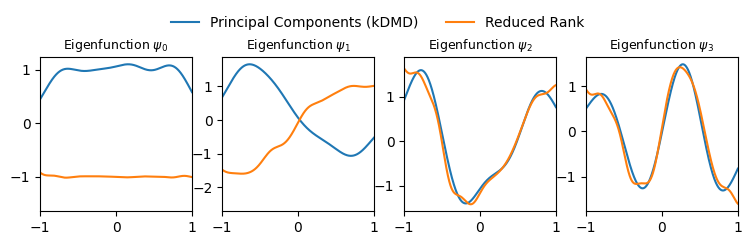

In [6]:
fig, axs = plt.subplots(ncols=4, figsize=(9, 2))
for fun_id, ax in enumerate(axs):
    for method, functions in results.items():
        color = "tab:blue" if "Principal" in method else "tab:orange"
        ax.plot(x, functions[0][:, fun_id], color=color, label=method)
    ax.set_title(rf"Eigenfunction $\psi_{fun_id}$", fontsize=9)
    ax.set_xlim(-1, 1)
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncols=2,
    frameon=False,
    bbox_to_anchor=(0.0, 1.05, 1.0, 0.102),
)

As we can see, some eigenfunctions seem to have a sign mismatch. This is to be expected, as the spectral decomposition is [not unique](https://math.stackexchange.com/questions/1702730/sign-of-normalized-eigenvector-for-singular-value-decomposition), and multiplying by a constant scalar value (including -1), returns a valid eigenvector. To overcome this issue, we can write down a simple helper function to standardize them

In [7]:
def standardize_sign(eigenfunction, reference, x):
    eigenfunction_cut = cut_functions_to_domain(eigenfunction, x)
    reference_cut = cut_functions_to_domain(reference, x)
    norm_p = np.linalg.norm(eigenfunction_cut + reference_cut)
    norm_m = np.linalg.norm(eigenfunction_cut - reference_cut)
    if norm_p <= norm_m:
        return -1.0*eigenfunction
    else:
        return eigenfunction

def cut_functions_to_domain(functions, x, x_lims=(-1, 1)):
    mask = (x >= x_lims[0]) & (x <= x_lims[1])
    return functions[mask]

def compute_ylims(reference, margin=0.1):
    ref_min = reference.min()
    ref_max = reference.max()
    if ref_min < 0:
        ref_min *= (1 + margin)
    else:
        ref_min *= (1 - margin)
    if ref_max < 0:
        ref_max *= (1 - margin)
    else:
        ref_max *= (1 + margin)

    y_min = np.round(ref_min, 1)
    y_max = np.round(ref_max, 1)
    return y_min, y_max

`kooplearn` also exposes the function [compute_prinz_potential_eig](../generated/kooplearn.datasets.compute_prinz_potential_eig.rst) returning the exact eigenfunctions associated to the Prinz Potential dynamics. We will now use it to get the reference eigenfunctions, so that we can compare our estimators:

In [8]:
from kooplearn.datasets import compute_prinz_potential_eig

dt = data.attrs["params"]["dt"]
_, reference_eigfuns = compute_prinz_potential_eig(
    gamma, sigma, dt, eval_right_on=x, num_components=5
)
reference_eigfuns = normalize_eigenfunctions(reference_eigfuns, x, density)

we can finally plot everything together

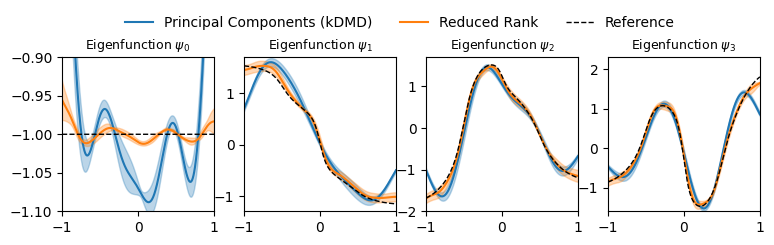

In [9]:
fig, axs = plt.subplots(ncols=4, figsize=(9, 2))
for fun_id, ax in enumerate(axs):
    reference = reference_eigfuns[:, fun_id]
    for method, functions in results.items():
        if method in ["Principal Components (kDMD)", "Reduced Rank"]:
            # Standardize signs according to the reference
            functions = np.array(functions) # Convert list of arrays into array
            for i in range(n_repetitions):
                for j in range(functions.shape[-1]):
                    functions[i, :, j] = standardize_sign(
                        functions[i, :, j], reference_eigfuns[:, j], x
                    )
            color = 'tab:blue' if 'Principal' in method else 'tab:orange'
            m = functions.mean(0)[:, fun_id]
            st = functions.std(0)[:, fun_id]
            ax.plot(x, m, color=color, label=method)
            ax.fill_between(x, m - st, m + st, color=color, alpha=0.3)
            ax.set_ylim(compute_ylims(reference))
    ax.plot(x, reference, color='k', lw=1, ls='--', label='Reference')
    ax.set_title(rf"Eigenfunction $\psi_{fun_id}$", fontsize=9)
    ax.set_xlim(-1, 1)
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncols=3,
    frameon=False,
    bbox_to_anchor=(0.0, 1.05, 1.0, 0.102),
)

...showing that the _Reduced Rank_ estimator approximates the reference eigenfunctions much better than the more common _Principal Component Regression_ (kernel DMD).

## A Representation Learning Approach
In this section, we move beyond prescribed feature maps and kernel methods. Here, we adopt a **representation learning** strategy. We aim to learn a mapping $\varphi$ that transforms the system's state into a latent space where the evolution of dynamics is linear, effectively approximating the eigenfunctions.


### Spectral Contrastive Loss
To achieve this, we train an encoder-only model optimized via the [SpectralContrastiveLoss](../generated/kooplearn.torch.nn.SpectralContrastiveLoss.rst).

The model architecture is twofold:
* **Encoder:** A Multilayer Perceptron (MLP) that lifts the state to the latent space.
* **Predictor:** A linear layer that evolves the state forward in time.

See *"Self-Supervised Evolution Operator Learning for High-Dimensional Dynamical Systems"* <cite data-footcite="turri2025self">(Turri et al. 2025)</cite> for the theoretical background.


In [10]:
import torch

n_train_samples = 5000
n_val_samples = 1000

subsample = 100
data = make_prinz_potential(X0=0, n_steps=int(7e5), gamma=gamma, sigma=sigma, random_state=0)
data = data.iloc[::subsample]  # ...but we don't need all the data to estimate the eigenfunctions

train_data = torch.from_numpy(data[:n_train_samples].values).float()
val_data = torch.from_numpy(data[-n_val_samples:].values).float()

In [11]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 512

# Creating PyTorch TensorDatasets
train_ds = TensorDataset(train_data[:-1], train_data[1:])
val_ds = TensorDataset(val_data[:-1], val_data[1:])

# Creating DataLoaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

In [12]:
# Experiment hyperparameters
learning_rate = 1e-2
opt = torch.optim.AdamW
num_epochs = 200
layer_dims = [32, 64, 32]
latent_dim = 32
random_state = 42

In [13]:
class SimpleMLP(torch.nn.Module):
    def __init__(
        self, latent_dim: int, layer_dims: list[int], activation=torch.nn.SiLU
    ):
        super().__init__()
        self.activation = activation
        lin_dims = ([1] + layer_dims + [latent_dim])

        layers = []

        for layer_idx in range(len(lin_dims)-2):
            layers.append(
                torch.nn.Linear(
                    lin_dims[layer_idx], lin_dims[layer_idx + 1], bias=False
                )
            )
            layers.append(activation())

        layers.append(torch.nn.Linear(lin_dims[-2], lin_dims[-1], bias=True))

        self.layers = torch.nn.ModuleList(layers)

    def forward(self, x):
        # MLP
        for layer in self.layers:
            x = layer(x)
        return x

In [14]:
from kooplearn.linear_model import Ridge
from kooplearn.torch.utils import FeatureMapEmbedder

device = "cuda" if torch.cuda.is_available() else "cpu"

class FeatureMap(torch.nn.Module):
    def __init__(self, latent_dim: int, normalize_latents: bool = False):
        super().__init__()
        self.normalize_latents = normalize_latents
        self.backbone = SimpleMLP(latent_dim=latent_dim, layer_dims=layer_dims)
        self.lin = torch.nn.Linear(latent_dim, latent_dim, bias=False)

    def forward(self, X, lagged: bool = False):
        z = self.backbone(X)
        if self.normalize_latents:
            z = torch.nn.functional.normalize(z, dim=-1)
        if lagged:
            z = self.lin(z)
        return z


def train_encoder_only(criterion: torch.nn.Module):
    torch.manual_seed(random_state)
    # Initialize model, loss and optimizer
    model = FeatureMap(latent_dim).to(device)
    optimizer = opt(model.parameters(), lr=learning_rate)

    def step(batch, is_train: bool = True):
        batch_X, batch_Y = batch
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        if is_train:
            optimizer.zero_grad()
        phi_X, phi_Y = model(batch_X), model(batch_Y, lagged=True)
        loss = criterion(phi_X, phi_Y)
        if is_train:
            loss.backward()
            optimizer.step()
        return loss.item()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = []
        for batch in train_dl:
            train_loss.append(step(batch))
        # Validation phase
        model.eval()
        val_loss = []
        with torch.no_grad():
            for batch in val_dl:
                val_loss.append(step(batch, is_train=False))

        if (epoch + 1) % 10 == 0 or (epoch == 0):
            print(
                f"EPOCH {epoch + 1:>2}  Loss: {np.mean(train_loss):.2f} (train) -  {np.mean(val_loss):.2f} (val)"
            )

    embedder = FeatureMapEmbedder(encoder=model, device=device)
    evolution_operator_model = Ridge(n_components=latent_dim).fit(
        embedder.transform(train_data), train_data.numpy(force=True)
    )

    return {
        "model": evolution_operator_model,
        "feature_map": embedder.transform,
    }

In [15]:
from kooplearn.torch.nn import SpectralContrastiveLoss

trained_models = {}
trained_models["Spectral Contrastive Loss"] = train_encoder_only(SpectralContrastiveLoss())

EPOCH  1  Loss: -0.85 (train) -  -1.81 (val)
EPOCH 10  Loss: -2.01 (train) -  -2.17 (val)
EPOCH 20  Loss: -2.51 (train) -  -2.44 (val)
EPOCH 30  Loss: -2.55 (train) -  -2.55 (val)
EPOCH 40  Loss: -2.96 (train) -  -2.93 (val)
EPOCH 50  Loss: -3.01 (train) -  -2.96 (val)
EPOCH 60  Loss: -2.99 (train) -  -2.89 (val)
EPOCH 70  Loss: -3.06 (train) -  -3.00 (val)
EPOCH 80  Loss: -3.08 (train) -  -3.02 (val)
EPOCH 90  Loss: -3.08 (train) -  -3.00 (val)
EPOCH 100  Loss: -3.04 (train) -  -2.99 (val)
EPOCH 110  Loss: -3.11 (train) -  -2.96 (val)
EPOCH 120  Loss: -3.10 (train) -  -2.96 (val)
EPOCH 130  Loss: -3.17 (train) -  -3.02 (val)
EPOCH 140  Loss: -3.16 (train) -  -3.05 (val)
EPOCH 150  Loss: -3.17 (train) -  -3.03 (val)
EPOCH 160  Loss: -3.16 (train) -  -3.06 (val)
EPOCH 170  Loss: -3.17 (train) -  -3.09 (val)
EPOCH 180  Loss: -3.18 (train) -  -3.07 (val)
EPOCH 190  Loss: -3.19 (train) -  -3.10 (val)


The rank attribute has been updated to 19.
Consider decreasing the rank parameter.


EPOCH 200  Loss: -3.16 (train) -  -3.03 (val)


In [ ]:
def estimate_representations(model, embedder, x, density):
    values, functions = model.eig(eval_right_on=embedder(x))  # Eigenvalue estimation
    sort_perm = np.flip(np.argsort(np.abs(values))) # Order eigenvalues decreasingly
    values, functions = values[sort_perm], functions[:, sort_perm]
    functions = normalize_eigenfunctions(functions, x, density)
    return functions

In [ ]:
for model_id, trained_model in trained_models.items():
    results[model_id] = [estimate_representations(trained_model["model"], trained_model["feature_map"], x[:, None], density)]

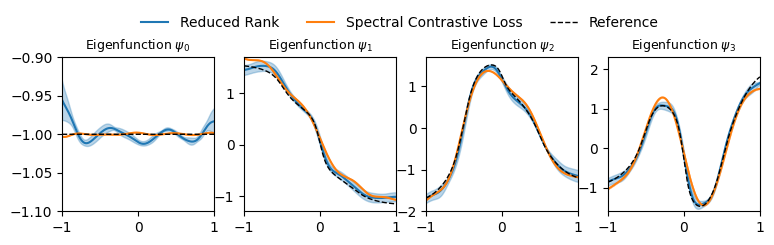

In [ ]:
fig, axs = plt.subplots(ncols=4, figsize=(9, 2))
for fun_id, ax in enumerate(axs):
    for method, functions in results.items():
        if method in ["Reduced Rank", "Spectral Contrastive Loss"]:
            # Standardize signs according to the reference
            functions = np.array(functions) # Convert list of arrays into array
            n_reps = functions.shape[0]
            for i in range(n_reps):
                for j in range(reference_eigfuns.shape[-1]):
                    functions[i, :, j] = standardize_sign(
                        functions[i, :, j], reference_eigfuns[:, j], x
                    )
            color = 'tab:blue' if 'Reduced Rank' in method else 'tab:orange'
            m = functions.mean(0)[:, fun_id].real
            st = functions.std(0)[:, fun_id].real
            ax.plot(x, m, color=color, label=method)
            ax.fill_between(x, m - st, m + st, color=color, alpha=0.3)
    reference = reference_eigfuns[:, fun_id]
    ax.plot(x, reference, color='k', lw=1, ls='--', label='Reference')
    ax.set_title(rf"Eigenfunction $\psi_{fun_id}$", fontsize=9)
    ax.set_xlim(-1, 1)
    ax.set_ylim(compute_ylims(reference))
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncols=3,
    frameon=False,
    bbox_to_anchor=(0.0, 1.05, 1.0, 0.102),
)

Notably, optimizing the mapping $\varphi$ with the [SpectralContrastiveLoss](../generated/kooplearn.torch.nn.SpectralContrastiveLoss.rst) enables a precise estimation of eigenfunctions—including the trivial constant function $\Psi_0$, which remains flat unlike in standard Reduced Rank models.

## Generator learning
Just like for the transfer operator approach, we will present two different methods: the first one using kernel methods, and then a second one leveraging neural networks and representation learning. 

In this part, we study the infinitesimal generator of a stochastic process, focusing on overdamped Langevin dynamics. The infinitesimal generator encodes the evolution of observables and plays a key role in analyzing long-time dynamics, metastable states, and spectral properties of the system.


---

### The infinitesimal Generator

The infinitesimal generator $\mathcal{L}$ describes the instantaneous evolution of smooth functions $f: \mathbb{R}^d \to \mathbb{R}$ under the stochastic dynamics:

$$
\mathcal{L} f(x) = \lim_{\Delta t \to 0} \frac{\mathbb{E}[f(X_{t + \Delta t}) \mid X_t = x] - f(x)}{\Delta t}.
$$

For the overdamped Langevin process, the generator takes the form:

$$
\mathcal{L} f(x) = - \frac{1}{\gamma} \nabla V(x) \cdot \nabla f(x) + \frac{\beta}{\gamma} \Delta f(x),
$$

where \($\Delta f = \nabla \cdot \nabla f$\) is the Laplacian.

### Link with the transfer operator

The **infinitesimal generator** governs the evolution of observables under the stochastic dynamics, we define

$$
u(x,t) = \mathbb{E}[f(X_t) \mid X_0 = x].
$$

It satisfies the **backward Kolmogorov equation**:

$$
\frac{\partial u}{\partial t}(x,t) = \mathcal{L} u(x,t), 
\quad u(x,0) = f(x).
$$

---

From the perspective of **transfer operators**:

- The **infinitesimal generator** is the derivative of the Koopman operator at \(t = 0\):

$$
\mathcal{L} f = \lim_{t \to 0} \frac{\mathcal{K}^t f - f}{t}.
$$

Thus, $\mathcal{L}$ can be viewed as the **infinitesimal generator of the semigroup** \(${\mathcal{K}^t}_{t \ge 0}$\).  
Eigenfunctions of $\mathcal{L}$ correspond to directions in function space that evolve exponentially under the Koopman operator:

$$
\mathcal{K}^t \phi = e^{\lambda t} \phi, \quad \mathcal{L} \phi = \lambda \phi.
$$

This perspective makes the connection between **generator-based approaches** and **data-driven Koopman analysis** explicit:  
learning $\mathcal{L}$ from data allows us to approximate the long-time dynamics, metastable states, and slow collective modes of the system.



We further train another model using the [EnergyLoss](../generated/kooplearn.torch.nn.EnergyLoss.rst). [TODO]

### Kernel methods
In this part we implement the method published in (Kostic et al 2024) based on the revolvent operator $ (\mu I - \mathcal{L})^{-1} $

In [ ]:
from kooplearn.kernel._generator import GeneratorDirichlet

def fit_and_estimate_generator( x, density):
    subsample = 100  # We need long trajectories to sample the Boltzmann distribution...
    gamma = 1.0
    sigma = 2.0
    data = make_prinz_potential(X0=0, n_steps=int(5e5), gamma=gamma, sigma=sigma)
    data = data.iloc[::subsample]  # ...but we don't need all the data to estimate the eigenfunctions
    model = GeneratorDirichlet(
        diffusion=sigma/gamma, n_components=5,  gamma=50, alpha=1e-5,shift=5
    )  # Model definition
    model.fit(data)
    values, functions = model.eig(eval_right_on=x)  # Eigenvalue estimation
    values, functions = values, functions
    functions = normalize_eigenfunctions(functions, x, density)
    return functions

In [ ]:



for _ in tqdm(range(n_repetitions)):
        results["generator"].append(fit_and_estimate_generator( x[:, None], density))

  0%|          | 0/10 [00:00<?, ?it/s]/home/tdevergne@iit.local/anaconda3/envs/kooplearn-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GeneratorDirichlet was fitted with feature names
  warnings.warn(
 10%|█         | 1/10 [01:07<10:11, 67.96s/it]/home/tdevergne@iit.local/anaconda3/envs/kooplearn-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GeneratorDirichlet was fitted with feature names
  warnings.warn(
 20%|██        | 2/10 [02:16<09:08, 68.54s/it]/home/tdevergne@iit.local/anaconda3/envs/kooplearn-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GeneratorDirichlet was fitted with feature names
  warnings.warn(
 30%|███       | 3/10 [03:25<08:00, 68.68s/it]/home/tdevergne@iit.local/anaconda3/envs/kooplearn-dev/lib/python3.10/site-packages/sklearn/utils/validation.p

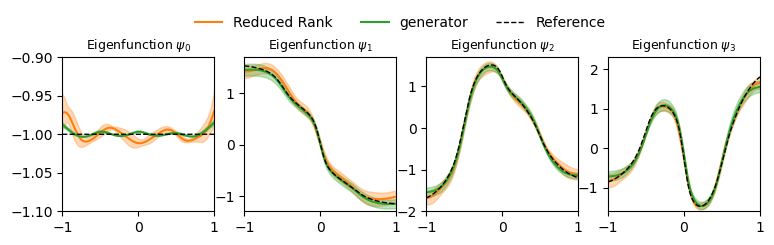

In [ ]:
fig, axs = plt.subplots(ncols=4, figsize=(9, 2))
for fun_id, ax in enumerate(axs):
    reference = reference_eigfuns[:, fun_id]
    for method, functions in results.items():
        if method in [ "Reduced Rank", "generator"]:
            # Standardize signs according to the reference
            functions = np.array(functions) # Convert list of arrays into array
            for i in range(n_repetitions):
                for j in range(functions.shape[-1]):
                    functions[i, :, j] = standardize_sign(
                        functions[i, :, j], reference_eigfuns[:, j], x
                    )
            color = 'tab:orange' if 'Reduced' in method else 'tab:green'
            m = functions.mean(0)[:, fun_id].real
            st = functions.std(0)[:, fun_id].real
            ax.plot(x, m, color=color, label=method)
            ax.fill_between(x, m - st, m + st, color=color, alpha=0.3)
            ax.set_ylim(compute_ylims(reference))
    ax.plot(x, reference, color='k', lw=1, ls='--', label='Reference')
    ax.set_title(rf"Eigenfunction $\psi_{fun_id}$", fontsize=9)
    ax.set_xlim(-1, 1)
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncols=3,
    frameon=False,
    bbox_to_anchor=(0.0, 1.05, 1.0, 0.102),
)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 512

# Creating PyTorch TensorDatasets
train_ds = TensorDataset(train_data[:-1])
val_ds = TensorDataset(val_data[:-1])

# Creating DataLoaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

In [34]:
from torch.func import functional_call, jacfwd, jacrev, vmap


class GeneratorFeatureMap(torch.nn.Module):
    def __init__(self, latent_dim: int, layer_dims: list[int], normalize_latents: bool = False):
        super().__init__()
        self.normalize_latents = normalize_latents
        self.backbone = SimpleMLP(latent_dim=latent_dim, layer_dims=layer_dims)

    def compute_jacobian(self, x):
        """
        Efficiently computes the Jacobian of the output embeddings w.r.t the input x.

        This method uses `torch.func.vmap` and `torch.func.jacrev` to compute
        gradients. This is significantly faster than loop-based approaches and 
        more memory-efficient than `torch.autograd.functional.jacobian` for batches.

        Parameters
        ----------
        x : torch.Tensor
            Input data of shape (batch_size, latent_dim).

        Returns
        -------
        torch.Tensor
            Jacobian tensor of shape (batch_size, latent_dim, output_dim).

            The element at index [b, i, j] corresponds to the partial derivative:
            $\\frac{\\partial \\text{output}[b, j]}{\\partial \\text{input}[b, i]}$
        """
        # Define a functional version of the forward pass for a single sample
        def func_forward(x_sample, params_buffers):
            out = functional_call(self.backbone, params_buffers, (x_sample,))
            if self.normalize_latents:
                out = torch.nn.functional.normalize(out, dim=-1)
            return out

        # Extract parameters/buffers (needed for functional_call)
        params = dict(self.backbone.named_parameters())
        buffers = dict(self.backbone.named_buffers())
        params_buffers = {**params, **buffers}

        # Compose vmap and jacrev
        # jacrev computes Jacobian of func_forward w.r.t arg 0 (x_sample)
        # vmap vectorizes this operation over the batch dimension (dim 0)
        compute_batch_jacobian = vmap(jacrev(func_forward, argnums=0), in_dims=(0, None))

        # Execute
        jacobian = compute_batch_jacobian(x, params_buffers)

        # jacrev returns (output_dim, input_dim).
        # Since we are mapping R^d -> R^l, jacrev gives dU/dx.
        # Check shapes: resulting shape from vmap is (batch, output_dim, input_dim)
        # You wanted (batch, input_dim, output_dim), so we transpose.
        return jacobian.permute(0, 2, 1)

    def forward(self, x, return_grad: bool = False):
        # Standard forward pass
        z = self.backbone(x)
        if self.normalize_latents:
            z = torch.nn.functional.normalize(z, dim=-1)

        if return_grad:
            jacobian = self.compute_jacobian(x)
            return z, jacobian
        return z

def train_encoder_only(criterion: torch.nn.Module):
    torch.manual_seed(random_state)
    # Initialize model, loss and optimizer
    model = GeneratorFeatureMap(latent_dim, layer_dims).to(device)
    optimizer = opt(model.parameters(), lr=learning_rate)

    def step(batch, is_train: bool = True):
        X = batch[0]
        X = X.to(device)
        if is_train:
            optimizer.zero_grad()
        phi_X, grad_phi_X = model(X, return_grad=True)
        loss = criterion(phi_X, grad_phi_X)
        if is_train:
            loss.backward()
            optimizer.step()
        return loss.item()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = []
        for batch in train_dl:
            train_loss.append(step(batch))
        # Validation phase
        model.eval()
        val_loss = []
        for batch in val_dl:
            val_loss.append(step(batch, is_train=False))

        if (epoch + 1) % 10 == 0 or (epoch == 0):
            print(
                f"EPOCH {epoch + 1:>2}  Loss: {np.mean(train_loss):.2f} (train) -  {np.mean(val_loss):.2f} (val)"
            )

    embedder = FeatureMapEmbedder(encoder=model, device=device)
    evolution_operator_model = Ridge(n_components=latent_dim).fit(
        embedder.transform(train_data), train_data.numpy(force=True)
    )

    return {
        "model": evolution_operator_model,
        "feature_map": embedder.transform,
    }

In [35]:
from kooplearn.torch.nn import EnergyLoss

trained_models["Energy Loss"] = train_encoder_only(EnergyLoss(grad_weight=1e-3))

EPOCH  1  Loss: -1.26 (train) -  -1.83 (val)
EPOCH 10  Loss: -2.89 (train) -  -2.80 (val)
EPOCH 20  Loss: -2.94 (train) -  -2.95 (val)
EPOCH 30  Loss: -3.82 (train) -  -3.76 (val)
EPOCH 40  Loss: -4.65 (train) -  -4.56 (val)
EPOCH 50  Loss: -5.39 (train) -  -5.33 (val)
EPOCH 60  Loss: -5.59 (train) -  -5.52 (val)
EPOCH 70  Loss: -6.47 (train) -  -6.50 (val)
EPOCH 80  Loss: -7.04 (train) -  -6.87 (val)
EPOCH 90  Loss: -7.10 (train) -  -6.37 (val)
EPOCH 100  Loss: -7.19 (train) -  -7.04 (val)
EPOCH 110  Loss: -7.29 (train) -  -7.18 (val)
EPOCH 120  Loss: -7.53 (train) -  -7.46 (val)
EPOCH 130  Loss: -8.36 (train) -  -8.29 (val)
EPOCH 140  Loss: -8.28 (train) -  -8.43 (val)
EPOCH 150  Loss: -8.68 (train) -  -8.42 (val)
EPOCH 160  Loss: -8.57 (train) -  -8.31 (val)
EPOCH 170  Loss: -8.84 (train) -  -8.69 (val)
EPOCH 180  Loss: -9.30 (train) -  -9.17 (val)
EPOCH 190  Loss: -9.29 (train) -  -9.18 (val)


The rank attribute has been updated to 19.
Consider decreasing the rank parameter.


EPOCH 200  Loss: -9.24 (train) -  -9.29 (val)


In [36]:
results["Energy Loss"] = [
    estimate_representations(
    trained_models["Energy Loss"]["model"],
    trained_models["Energy Loss"]["feature_map"],
    x[:, None], density
    )
    ]

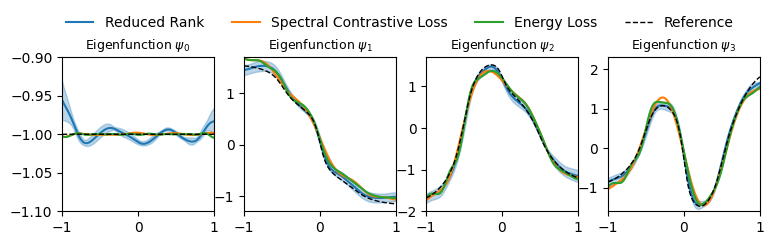

In [37]:
fig, axs = plt.subplots(ncols=4, figsize=(9, 2))
for fun_id, ax in enumerate(axs):
    for method, functions in results.items():
        if method in ["Reduced Rank", "Spectral Contrastive Loss", "Energy Loss"]:
            # Standardize signs according to the reference
            functions = np.array(functions) # Convert list of arrays into array
            n_reps = functions.shape[0]
            for i in range(n_reps):
                for j in range(reference_eigfuns.shape[-1]):
                    functions[i, :, j] = standardize_sign(
                        functions[i, :, j], reference_eigfuns[:, j], x
                    )
            # Color mapping for different methods
            color_map = {
                "Reduced Rank": "tab:blue",
                "Spectral Contrastive Loss": "tab:orange",
                "Energy Loss": "tab:green",
            }
            color = color_map.get(method, "tab:blue")
            m = functions.mean(0)[:, fun_id].real
            st = functions.std(0)[:, fun_id].real
            ax.plot(x, m, color=color, label=method)
            ax.fill_between(x, m - st, m + st, color=color, alpha=0.3)
    reference = reference_eigfuns[:, fun_id]
    ax.plot(x, reference, color='k', lw=1, ls='--', label='Reference')
    ax.set_title(rf"Eigenfunction $\psi_{fun_id}$", fontsize=9)
    ax.set_xlim(-1, 1)
    ax.set_ylim(compute_ylims(reference))
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncols=4,
    frameon=False,
    bbox_to_anchor=(0.0, 1.05, 1.0, 0.102),
)